# Chapters 15 & 16:
# Metrics and Regression Evaluation & Explaining Regression Models

In [2]:
# Basic Libraries

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

import pandas as pd
import numpy as np

In [3]:
# Specific Libraries

from sklearn.experimental import enable_iterative_imputer
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.model_selection import ValidationCurve

### The Dataset

In [5]:
# Boston Housing Dataframe

from sklearn.datasets import fetch_openml

# Fetch the Boston housing dataset from openml
boston_data = fetch_openml(data_id=531, as_frame=True)
bos_X = boston_data.data
bos_y = boston_data.target

# Split the dataset into training and testing sets with 30% of data as the test set
bos_X_train, bos_X_test, bos_y_train, bos_y_test = model_selection.train_test_split(
    bos_X,          # Feature data (input variables)
    bos_y,          # Target data (output variable)
    test_size=0.3,  # Size of the test set as a fraction of the whole dataset
    random_state=42 # Random seed to ensure reproducibility
)

# Standardize the feature data (subtract the mean and scale to unit variance)
bos_sX = preprocessing.StandardScaler().fit_transform(bos_X)

# Split the standardized data into training and testing sets
bos_sX_train, bos_sX_test, bos_sy_train, bos_sy_test = model_selection.train_test_split(
    bos_sX,         # Standardized feature data
    bos_y,          # Target data (output variable)
    test_size=0.3,  # Size of the test set as a fraction of the whole dataset
    random_state=42 # Random seed to ensure reproducibility
)

### Random Forest
Decision trees are good because they are explainable, but they have a tendency to overfit. A random forest trades some of the
explainability for a model that tends to generalize better. This model can also be used for regression.

In [7]:
from sklearn.ensemble import RandomForestRegressor


# Initialize the random forest regressor model with a specific random state and number of trees
rfr = RandomForestRegressor(
    random_state=42,  # Set random state for reproducibility
    n_estimators=100  # Use 100 trees
)

# Train the random forest regressor model on the training dataset
rfr.fit(bos_X_train, bos_y_train)

RandomForestRegressor(random_state=42)

# Metrics and Regression Evaluation

### Metrics
Metric functions ending in loss or error should be minimized. Functions ending in score should be maximized.

In [10]:
# Calculate and return the R^2 score of the Random Forest Regressor on the test data, indicating model accuracy.
rfr.score(bos_X_test, bos_y_test)

0.8708997131330258

The coefficient of determination (r²) is a common regression metric. This value is typically between 0 and 1. It represents the percent of the variance of the target that the features contribute. Higher values are better, but in general it is difficult to evaluate the model from this metric alone.

In [12]:
from sklearn import metrics

bos_y_test_pred = rfr.predict(bos_X_test)      # Generate predictions on the test data using the Random Forest Regressor
metrics.r2_score(bos_y_test, bos_y_test_pred)  # Calculate and return the R^2 score, comparing actual vs. predicted values to measure model accuracy

0.8708997131330258

The explained variance score indicates how much of the variance in the data the model captures; a score closer to 1 implies that the model explains most of the variance, whereas 0 means it does not.

In [14]:
metrics.explained_variance_score(                # Calculate the explained variance score, a metric to measure model's performance
    bos_y_test,                                  # True values of the target variable in the test set
    bos_y_test_pred                              # Predicted values by the model on the test set
)

0.87128003640625

**Mean absolute error** (`neg_mean_absolute_error` when used in grid search) expresses the average absolute model prediction
error. A perfect model would score 0, but this metric has no upper bounds, unlike the coefficient of determination. However, since it is in units of the target, it is more interpretable. If you want to ignore outliers, this is a good metric to use.

In [16]:
metrics.mean_absolute_error(                    # Calculate the Mean Absolute Error (MAE), a measure of error magnitude
    bos_y_test,                                 # True values of the target variable in the test set
    bos_y_test_pred                             # Predicted values by the model on the test set
)

np.float64(2.083605263157894)

MAE provides an average of absolute differences between predicted and actual values, giving a straightforward view of prediction accuracy; lower values indicate better model performance.

**Root mean squared error** (`neg_mean_squared_error` in grid search) also measures model error in terms of the target. However, because it averages the square of errors before taking the square root, it penalizes large errors. If you want to penalize large errors, this is a good metric to use. As with mean absolute error, this measure cannot indicate how bad a model is, but can be used to compare two models. If you
assume that errors are normally distributed, this is a good choice.

In [19]:
metrics.mean_squared_error(                   # Calculate the Mean Squared Error (MSE), measuring the average squared differences
    bos_y_test,                               # True target values for the test set
    bos_y_test_pred                           # Predicted values from the model on the test set
)

np.float64(9.619662013157892)

MSE calculates the squared differences between predicted and actual values; larger errors are penalized more heavily, making this metric sensitive to outliers. Lower MSE values indicate better predictive accuracy of the model.

The mean squared logarithmic error (in grid search, `neg_mean_squared_log_error`) penalizes underprediction more than overprediction. If you have targets that experience exponential growth (population, stock, etc.), this is a good metric. If you take the log of the error and then square it, the average of these results will be 0.021

In [22]:
metrics.mean_squared_log_error(               # Calculate the Mean Squared Logarithmic Error (MSLE)
    bos_y_test,                               # True values from the test set
    bos_y_test_pred                           # Predicted values from the model for the test set
)

np.float64(0.02128735507001923)

MSLE measures the ratio between actual and predicted values; it penalizes under-predictions more than over-predictions, which is useful for data with wide value ranges or where relative differences matter. Lower MSLE indicates predictions closer to actual values, especially for smaller errors.

### Residuals Plot
Good models (with appropriate R2 scores) will exhibit *homoscedasticity*. This means the variance is the same for all values of targets regardless of the input. Plotted, this looks like ran‐
domly distributed values in a residuals plot. If there are patterns, the model or the data are problematic.
    
Residuals plots also show outliers, which can have a big impact on model fitting.

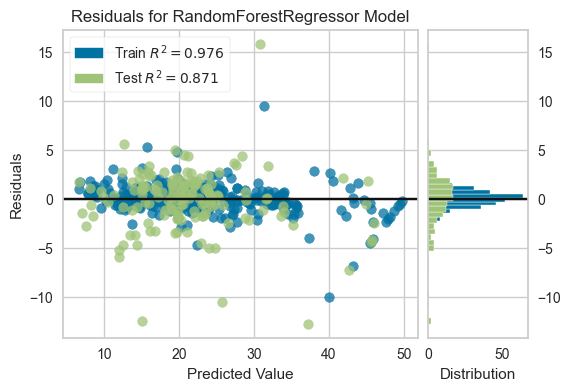

In [25]:
import warnings                                    
from yellowbrick.regressor import ResidualsPlot 

# Suppress specific warnings for this cell
with warnings.catch_warnings():
    warnings.simplefilter("ignore")                  # Ignore all warnings within this context

    fig, ax = plt.subplots(figsize=(6, 4))           # Create a figure with specified dimensions for the plot
    rpv = ResidualsPlot(rfr)                         # Initialize the residual plot visualizer with the trained random forest regressor
    rpv.fit(bos_X_train, bos_y_train)                # Fit the visualizer using the training data
    rpv.score(bos_X_test, bos_y_test)                # Evaluate the model on test data, adding the residuals to the plot
    rpv.poof();                                      # Display the plot showing residuals against predicted values

*Residuals Plot shows the difference between actual and predicted values, helping identify any patterns in errors which might indicate model issues like bias or variance.*

* The high 𝑅^2 score on the training data compared to the test data could indicate a slight overfitting, as the model performs marginally better on the training data.

* The histogram on the right shows a mostly symmetric distribution around zero, which is desirable as it indicates that errors are not systematically biased in one direction.

* Overall, the RandomForestRegressor model performs well, capturing the general trend in both training and test data. 

### Heteroscedasticity

The statsmodel library includes the **Breusch-Pagan** test for *heteroscedasticity*. This means that variance of the residuals varies
over the predicted values. In the Breusch-Pagan test, if the pvalues are significant (p-value less than 0.05), the null hypothesis of homoscedasticity is rejected. This indicates that residuals
are heteroscedastic, and the predictions are biased.

In [29]:
import statsmodels.api as sm                      # Import statsmodels for adding a constant column
import statsmodels.stats.api as sms               # Import the stats module for statistical tests

# Calculate residuals by subtracting predicted values from actual values
resids = bos_y_test - rfr.predict(bos_X_test)     

# Add a constant column to bos_X_test to meet the requirement for the Breusch-Pagan test
bos_X_test_const = sm.add_constant(bos_X_test)    

# Perform the Breusch-Pagan test for heteroscedasticity using the residuals and adjusted test features
hb = sms.het_breuschpagan(resids, bos_X_test_const)

# Define labels for the Breusch-Pagan test output
labels = [
    "Lagrange multiplier statistic",  # Indicates the Lagrange multiplier statistic value
    "p-value",                        # Indicates the p-value for the test
    "f-value",                        # Indicates the f-statistic value
    "f p-value",                      # Indicates the p-value for the f-statistic
]

# Loop through the labels and results from the test, printing each with a label
for name, num in zip(labels, hb):
    print(f"{name}: {num:.2}")        # Print each label and corresponding test result, formatted to 2 decimal places

Lagrange multiplier statistic: 2.2e+01
p-value: 0.05
f-value: 1.8
f p-value: 0.044


* Lagrange Multiplier Statistic (LM Statistic): 22.0. A higher value indicates stronger evidence against the null hypothesis of homoscedasticity (constant variance of residuals).

* A p-value close to 0.05 suggests borderline statistical significance, this as marginal evidence against homoscedasticity.

* f-value: 1.8. A higher f-value generally provides more evidence of heteroscedasticity.

* f p-value: 0.044. A value of 0.044 suggests that there is significant evidence at the 0.05 level to reject the null hypothesis of homoscedasticity.

The variance of the residuals might not be constant across the range of predictors.

### Normal Residuals
The scipy library includes a probability plot and the **Kolmogorov-Smirnov** test, both of which measure whether the residuals are normal.
We can plot a histogram to visualize the residuals and check for *normality*:

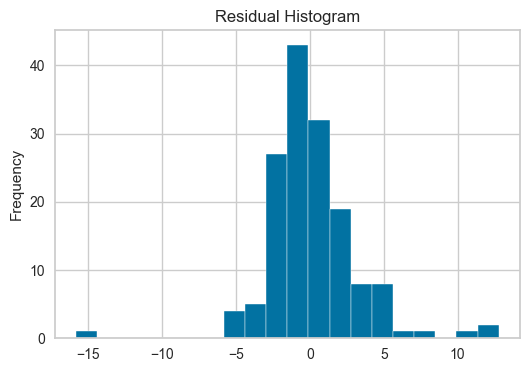

In [32]:
fig, ax = plt.subplots(figsize=(6, 4))                 # Create a figure and axis with specified size for plotting

resids = bos_y_test - rfr.predict(bos_X_test)          # Calculate residuals by subtracting predicted values from actual test values

# Create a histogram plot of the residuals
pd.Series(resids, name="residuals").plot.hist(         # Convert residuals to a Pandas Series and plot as a histogram
    bins=20,                                           # Set number of bins to 20 for histogram granularity
    ax=ax,                                             # Use the previously created axis for the plot
    title="Residual Histogram"                         # Set the title of the plot
);

If the samples plotted against the quantiles line up, the residuals are normal. We can see that this fails in this case:

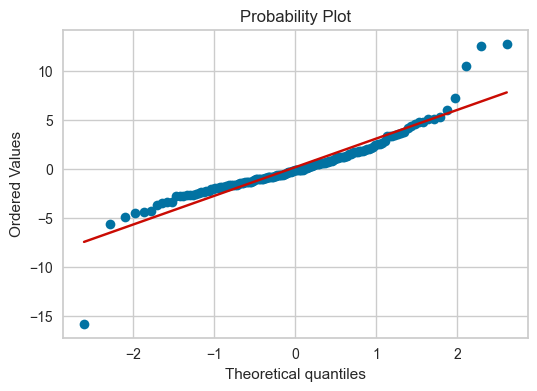

In [34]:
from scipy import stats

fig, ax = plt.subplots(figsize=(6, 4))      # Create a figure and axis with specified size for plotting

_ = stats.probplot(resids, plot=ax)         # Generate a Q-Q plot to assess normality of residuals
                                            # The function compares residuals to a theoretical normal distribution
                                            # The underscore (_) ignores any returned values, focusing only on the plot

This is a Q-Q (Quantile-Quantile) plot, which compares the residuals of the model (the differences between predicted and actual values) to a normal distribution. Here’s how to interpret the plot and some insights:

Interpretation of the Line:

* The red line represents the ideal case where the residuals perfectly follow a normal distribution. If the residuals align closely with this line, it indicates that the residuals are approximately normally distributed.

Observations:

* Central Points: Most of the points lie close to the red line in the middle range, indicating that for a majority of the residuals, the distribution is approximately normal.

* Tail Behavior: At both extremes (left and right ends), the points start deviating from the line, particularly with some points noticeably above the line on the right and below it on the left. This pattern suggests the presence of outliers or heavy tails, where some predictions are significantly off from the actual values.

Conclusion:

* Overall, this Q-Q plot suggests the model performs reasonably well, with a few areas for improvement due to outliers or deviations from normality at the tails.

#### Kolmogorov-Smirnov test 

The The Kolmogorov-Smirnov test can evaluate whether a distribution is normal. If the p-value is significant (< 0.05), then the values are not normal.
This fails as well, which tells us the residuals are not normal: 

In [38]:
from scipy import stats

# Perform the Kolmogorov-Smirnov test
ks_result = stats.kstest(resids, cdf="norm")

# Generate a human-readable printout
print(f"Kolmogorov-Smirnov Test for Normality\n")
print(f"Statistic (D):       {ks_result.statistic:.3f}")
print(f"p-value:             {ks_result.pvalue:.6f}")
print(f"Statistic Location:  {ks_result.statistic_location:.3f}")
print(f"Statistic Sign:      {'+' if ks_result.statistic_sign > 0 else '-'}{abs(ks_result.statistic_sign)}\n")

# Interpretation
if ks_result.pvalue < 0.05:
    print("Interpretation: The result indicates that the residuals are significantly different from a normal distribution.")
else:
    print("Interpretation: The result suggests that the residuals do not significantly deviate from a normal distribution.")

Kolmogorov-Smirnov Test for Normality

Statistic (D):       0.203
p-value:             0.000006
Statistic Location:  -1.363
Statistic Sign:      +1

Interpretation: The result indicates that the residuals are significantly different from a normal distribution.


#### Explanation of Each Value:

`Statistic (D): 0.203`

This value represents the maximum distance between the empirical distribution of the residuals and the theoretical cumulative distribution function (CDF) of a normal distribution. A higher D statistic indicates a larger deviation from the expected distribution.

`p-value: 0.000006`

The p-value is the probability of observing a test statistic as extreme as, or more extreme than, the one observed, assuming the null hypothesis (that the residuals follow a normal distribution) is true. A p-value this low suggests strong evidence against the null hypothesis.

`Statistic Location: -1.363`

This indicates the specific point in the data (i.e., the residual value) where the maximum difference between the empirical and theoretical CDFs occurs.

`Statistic Sign: +1`

This shows the direction of the deviation at the location of the maximum distance. A +1 means the empirical distribution is above the theoretical distribution at this point.

**Interpretation:**

The K-S test result suggests that the residuals deviate significantly from a normal distribution (as indicated by the very small p-value). This deviation is reflected by a notable D statistic and the identified location where the deviation is most significant (-1.363).

### Prediction Error Plot

A prediction error plot shows the real targets against the predicted values. For a perfect model these points would line up in
a 45-degree line.

As our model seems to predict lower values for the high end of y, the model has some performance issues. This is also evident
in the residuals plot.

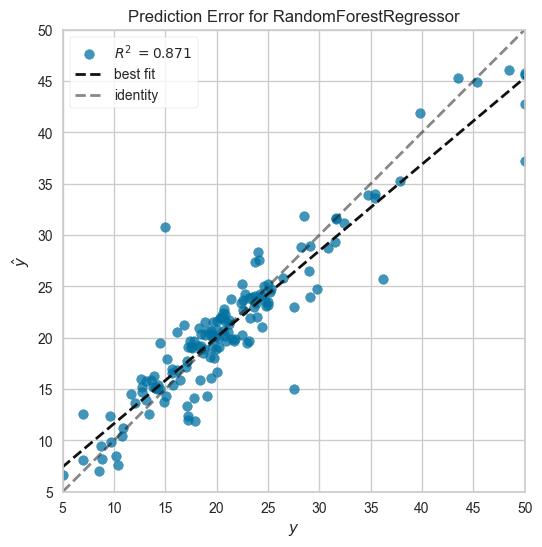

In [42]:
import warnings                                    
from yellowbrick.regressor import PredictionError 

# Suppress specific warnings for this cell
with warnings.catch_warnings():
    warnings.simplefilter("ignore")         # Ignore all warnings within this context

    fig, ax = plt.subplots(figsize=(6, 6))  # Create a figure and axis with specified dimensions for the plot
    pev = PredictionError(rfr)              # Initialize the PredictionError visualizer with the trained random forest regressor
    pev.fit(bos_X_train, bos_y_train)       # Fit the visualizer using the training data to learn the relationship between true and predicted values
    pev.score(bos_X_test, bos_y_test)       # Evaluate the model on the test data and add the prediction error to the plot
    pev.poof();                             # Display the plot showing the prediction errors

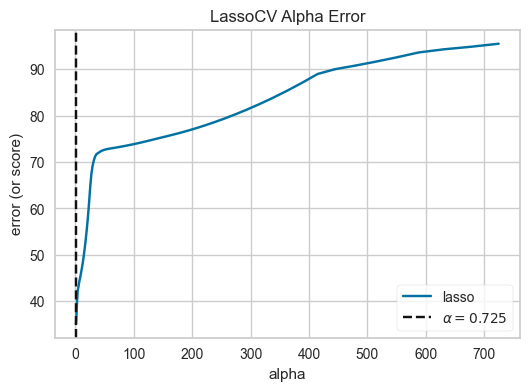

In [43]:
from sklearn.linear_model import LassoCV
from yellowbrick.regressor import AlphaSelection

fig, ax = plt.subplots(figsize=(6, 4)) # Create a figure and axis with specified dimensions for the plot
asv = AlphaSelection(LassoCV(cv=5))    # Initialize the AlphaSelection visualizer with a LassoCV model, using 5-fold cross-validation
asv.fit(bos_X, bos_y)                  # Fit the visualizer to the data, allowing it to select the optimal alpha for Lasso regularization
asv.poof();                            # Display the plot showing the cross-validation scores and selected alpha value

1. **X-Axis (Alpha)**:

The X-axis represents different alpha values (regularization strength). Alpha is a parameter that controls the amount of regularization applied in Lasso regression. Smaller values of alpha allow the model to fit closer to the data (less regularization), while larger values introduce more regularization, which can simplify the model.

2. **Y-Axis (Error or Score)**:

The Y-axis represents the error or score of the model. In this context, the lower the value, the better the model's performance.

3. **Curve**:

The blue line represents how the error changes as alpha varies. Initially, the error is relatively low at smaller alpha values, indicating a good fit to the training data. As alpha increases, the error rises, suggesting that the model's performance degrades due to excessive regularization.

4. **Optimal Alpha Line**:

The vertical dashed black line represents the selected optimal alpha value found by LassoCV. In this case, the optimal alpha is approximately 0.725. This is the point where the error is minimized without overfitting or excessive regularization.

# Explaining Regression Models

In [46]:
import xgboost as xgb

xgr = xgb.XGBRegressor(             # Initialize an XGBoost regressor model
    random_state=42,                # Set the random state for reproducibility
    base_score=0.5,                 # Set the initial prediction score for all instances
    enable_categorical=True         # Enable handling of categorical data
)

xgr.fit(bos_X_train, bos_y_train)   # Fit the model to the training data

XGBRegressor(base_score=0.5, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### Analyzing a specific house

In [48]:
sample_idx = 5                         # Specify the index of the sample to be predicted
xgr.predict(bos_X.iloc[[sample_idx]])  # Use the trained XGBoost model to predict the target value

array([28.698582], dtype=float32)

#### Using Lime

In [50]:
from lime.lime_tabular import LimeTabularExplainer 

# Encode both training and test sets
bos_X_encoded = pd.get_dummies(bos_X)
bos_X_train_encoded = pd.get_dummies(bos_X_train)
bos_X_test_encoded = pd.get_dummies(bos_X_test)

# Align the training and test sets to match the original model's input features
bos_X_train_encoded, bos_X_test_encoded = bos_X_train_encoded.align(bos_X_train, join='right', axis=1, fill_value=0)

# Ensure that the encoded training and test sets have the same columns as the original training data
bos_X_train_encoded, bos_X_test_encoded = bos_X_train_encoded.align(bos_X_train_encoded, join='left', axis=1, fill_value=0)

# Recreate the LimeTabularExplainer with the aligned training data
explainer = LimeTabularExplainer(
    bos_X_train_encoded.values,                  # Use the processed training data
    feature_names=bos_X_train_encoded.columns,   # Provide the feature names for the training data
    class_names=['Price'],                       # Specify the name of the target variable for context
    mode='regression'                            # Set the explainer mode to 'regression' for explaining regression models
)

# Ensure the same column order for prediction
bos_X_test_encoded = bos_X_test_encoded[bos_X_train_encoded.columns]

# Explain a specific instance using the processed test data
sample_idx = 5                                   # Set the index of the instance to be explained
exp = explainer.explain_instance(
    bos_X_test_encoded.iloc[sample_idx].values,  # Pass the specific instance to be explained as a NumPy array
    xgr.predict,                                 # Provide the model's prediction function for explanations
    num_features=10                              # Limit the explanation to the top 10 most impactful features
)

# Display the explanation
exp.show_in_notebook(show_table=True)

In [51]:
from lime.lime_tabular import LimeTabularExplainer


# Step 1: Encode both training and test sets with one-hot encoding
bos_X_encoded = pd.get_dummies(bos_X)
bos_X_train_encoded = pd.get_dummies(bos_X_train)
bos_X_test_encoded = pd.get_dummies(bos_X_test)

# Step 2: Align the training and test sets to match the original model's input features
bos_X_train_encoded, bos_X_test_encoded = bos_X_train_encoded.align(bos_X_train, join='right', axis=1, fill_value=0)

# Step 3: Ensure that the encoded training and test sets have the same columns
bos_X_train_encoded, bos_X_test_encoded = bos_X_train_encoded.align(bos_X_train_encoded, join='left', axis=1, fill_value=0)

# Step 4: Recreate the LimeTabularExplainer with the aligned training data
explainer = LimeTabularExplainer(
    bos_X_train_encoded.values,                  # Use the processed training data
    feature_names=bos_X_train_encoded.columns,   # Provide the feature names for the training data
    class_names=['Price'],                       # Specify the name of the target variable for context
    mode='regression'                            # Set the explainer mode to 'regression' for explaining regression models
)

# Step 5: Ensure the same column order for prediction in the model
bos_X_test_encoded = bos_X_test_encoded[bos_X_train_encoded.columns]

# Step 6: Model prediction to verify alignment
sample_idx = 5                                   # Set the index of the instance to be explained
aligned_instance = bos_X_test_encoded.iloc[[sample_idx]]
model_prediction = xgr.predict(aligned_instance)
print(f"Model Prediction (aligned data): {model_prediction[0]}")
print()

# Step 7: Create a lambda function for LIME that uses one-hot encoded data
exp = explainer.explain_instance(
    bos_X_test_encoded.iloc[sample_idx].values,  # Pass the one-hot-encoded instance for LIME
    lambda x: xgr.predict(pd.DataFrame(x, columns=bos_X_train.columns)),  # Use original columns for prediction
    num_features=10                              # Limit the explanation to the top 10 most impactful features
)

# Step 8: Display the explanation
exp.show_in_notebook(show_table=True)


Model Prediction (aligned data): 23.4091854095459



### General Analysis

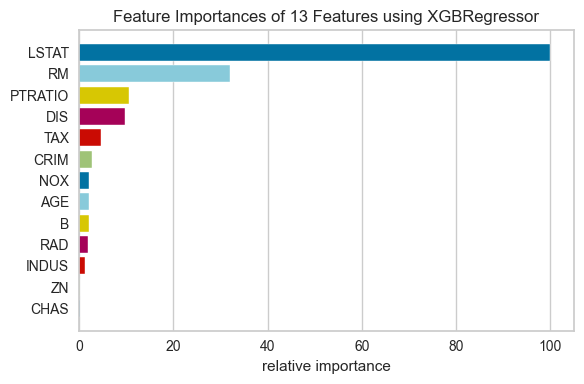

In [53]:
from yellowbrick.features import FeatureImportances

fig, ax = plt.subplots(figsize=(6, 4))                  # Create a figure and axis with specific dimensions
fi_viz = FeatureImportances(xgr, labels=bos_X.columns)  # Initialize FeatureImportances with XGBoost model and feature names
fi_viz.fit(bos_X_train, bos_y_train)                    # Fit the visualizer to the training data
fi_viz.show();                                          # Display the feature importance plot

#fig.savefig("mlpr_1406.png", dpi=300)

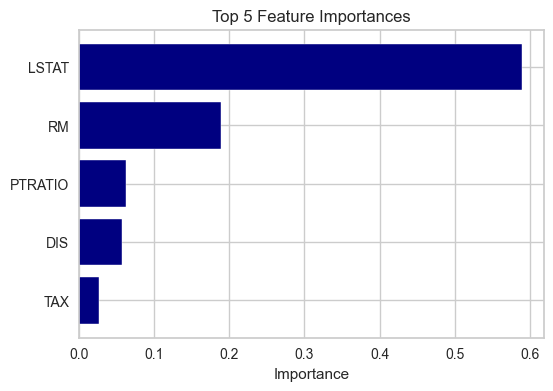

In [54]:
# Get feature importances and sort them in descending order
feature_importances = sorted(
    zip(bos_X.columns, xgr.feature_importances_),
    key=lambda x: x[1],
    reverse=True
)[:5]  # Select the top 5 features

# Split feature names and their importance values for plotting
features, importances = zip(*feature_importances)

# Create the bar chart
plt.figure(figsize=(6, 4))
plt.barh(features, importances, color='navy')
plt.xlabel('Importance')
plt.title('Top 5 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance on top
plt.show();